# Install detectron2

In [7]:
### it may be necessary to restart the kernel after installation (for whatever reason)
!pip install --upgrade pip
import torch, torchvision
if torch.version.cuda == '10.0.130':
    !pip install --upgrade pip
    !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
    !pip install cython pyyaml==5.1
    !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
elif torch.version.cuda == '10.1':
    !pip install cython 
    !pip install pyyaml
    !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
else:
    print(torch.version.cuda)

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.0.2)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-hs1dy5m_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-hs1dy5m_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279387 sha256=c8509446b70c418e6de9d61d86ded860392ddc5455ceb05f36961db81309a946
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrq5l022/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


# Imports

In [1]:
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
#from wsi import tiles, util

from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
#from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import random

 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
EXTRA_DATA = PATH/'extra_data'

STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution.csv'

STAGE2_TEST = PATH/'stage2_test_final'
STAGE2_TEST_SAMPLE_SUBMISSION = PATH/'stage2_sample_submission_final.csv'


seed = 19
np.random.seed(seed)

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

# util functions

In [3]:
def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()
    
from matplotlib.pyplot import imshow
def show_pil(path:pathlib.Path):    
    imshow(np.asarray(Image.open(path)))
    plt.show()

def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    return merge_masks([open_mask_as_np(p) for p in path.ls()], shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

#!pip install imantics
import imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# some util examples

## load csv

In [31]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image - example

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask - example

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth - example

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

## Custom dataset for nuclei detection

# Data

## image paths

In [4]:
excluded_ids = ['7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80']

img_paths = [p/'images'/f'{p.name}.png' for p in STAGE1_TRAIN.ls()+STAGE1_TEST.ls()+EXTRA_DATA.ls() if p.name not in excluded_ids]
img_paths_train, img_paths_valid = train_test_split(img_paths, test_size=0.1, random_state=seed)
print(len(img_paths))
print(len(img_paths_train))
print(len(img_paths_valid))

764
687
77


## custom dataset getter

In [5]:
df_rle_labels = pd.concat([pd.read_csv(STAGE1_TRAIN_LABELS), 
                             pd.read_csv(STAGE1_TEST_LABELS)], 
                            ignore_index=True, sort=False)

def get_nuclei_dicts(img_paths:List[pathlib.Path], isTestSet:bool=False):
    """
    Arguments:
        dataset_path: List of pathlib.Path to images
    """    
    dataset_dicts = []
    for path in tqdm(img_paths):
        record = {}
        
        img_pil = PIL.Image.open(path)         
        width = img_pil.width
        height = img_pil.height
        
        record["file_name"] = path
        record["image_id"] = path.stem
        record["height"] = height
        record["width"] = width
        
        ###
        #stage1_test set: masks only in run length encoded form in csv file
        #extra_data set: masks only saved as images
        ###
        try:
            masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
        except FileNotFoundError:
            masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
        
        objs = []
        if not isTestSet:
            for mask in masks:
                obj = {
                    "bbox": list(mask_to_bbox(mask)),
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": [get_polygon_from_binary_mask(mask)],
                    #"segmentation": rle_encode_pycoco(mask),
                    "category_id": 0,
                    "iscrowd": 0
                }
                ### detectron throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## register datasets

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()

DatasetCatalog.register("nuclei_train", lambda : get_nuclei_dicts(img_paths_train))
MetadataCatalog.get(f"nuclei_train").set(thing_classes=["nucleus"])

DatasetCatalog.register("nuclei_valid", lambda : get_nuclei_dicts(img_paths_valid))
MetadataCatalog.get(f"nuclei_valid").set(thing_classes=["nucleus"])

Metadata(name='nuclei_valid', thing_classes=['nucleus'])

## load datasets

In [ ]:
nuclei_metadata_train = MetadataCatalog.get(f"nuclei_train")
dataset_dicts_nuclei_train = get_nuclei_dicts(img_paths_train)

In [12]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [13]:
#for d in dataset_dicts_nuclei:
#    for a in d["annotations"]:
#        polygon = a['segmentation']
#        #print(len(polygon[0]))
#        try:
#            assert len(polygon[0]) % 2 == 0 and len(polygon[0]) >= 6
#        except AssertionError:
#            print(len(polygon[0]))

## sort dataset by number of nuclei and inspect it

In [14]:
#key: img_path; value: number of nuclei
path_to_n_objects = {}

for ds in [dataset_dicts_nuclei_train, dataset_dicts_nuclei_valid]:
    for d in ds:
        path_to_n_objects[d['file_name']] = len(d['annotations'])
        
#sort descending by number of nuclei
path_to_n_objects = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=True)}

In [15]:
print(f'max number of objects: {list(path_to_n_objects.values())[0]}')
print(f'min number of objects: {list(path_to_n_objects.values())[-1]}')

max number of objects: 1862
min number of objects: 1


In [ ]:
for k, v in list(path_to_n_objects.items())[300:320]:
    print(k)
    print(v)
    show_pil(k)

## some visualization of the data

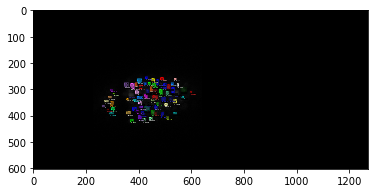

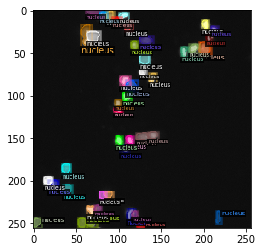

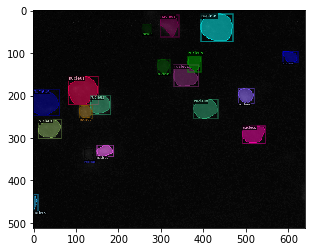

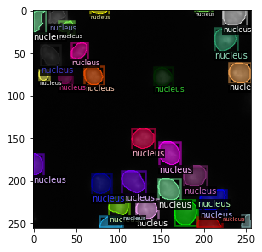

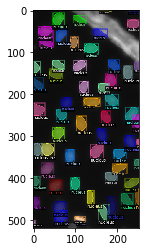

In [17]:
#for d in random.sample(dataset_dicts_nuclei, 3):
for d in dataset_dicts_nuclei_valid[:5]:
    #print(d["file_name"])
    img = cv2.imread(str(d["file_name"]))
    #img = np.asarray(Image.open(p))
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata_valid, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

# config 

In [7]:
from detectron2.config import get_cfg

In [8]:
epochs = 40
bs = 1
iterations = int(len(img_paths_train)/bs*epochs);iterations

27480

In [9]:
output_directory = Path('./output/2')

In [10]:
get_cfg().MODEL.RPN

CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'SMOOTH_L1_BETA': 0.0, 'LOSS_WEIGHT': 1.0, 'PRE_NMS_TOPK_TRAIN': 12000, 'PRE_NMS_TOPK_TEST': 6000, 'POST_NMS_TOPK_TRAIN': 2000, 'POST_NMS_TOPK_TEST': 1000, 'NMS_THRESH': 0.7})

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (f"nuclei_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 20

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 2.5e-3  
cfg.SOLVER.MAX_ITER = iterations
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 0.3*iterations
#cfg.SOLVER.LR_SCHEDULER_NAME = 'OneCycleLR'

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000

cfg['SEED'] = seed

cfg.OUTPUT_DIR = str(output_directory)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train

In [19]:
from detectron2.engine import DefaultTrainer

In [20]:
trainer = DefaultTrainer(cfg) 

[04/06 19:04:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res


[04/06 19:11:29 d2.data.build]: Removed 0 images with no usable annotations. 687 images left.
[04/06 19:11:29 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  nucleus   | 45672        |
|            |              |
[04/06 19:11:29 d2.data.common]: Serializing 687 elements to byte tensors and concatenating them all ...
[04/06 19:11:30 d2.data.common]: Serialized dataset takes 28.30 MiB
[04/06 19:11:30 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/06 19:11:30 d2.data.build]: Using training sampler TrainingSampler


In [21]:
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [22]:
trainer.train()

[04/06 19:11:35 d2.engine.train_loop]: Starting training from iteration 0
[04/06 19:11:44 d2.utils.events]:  eta: 2:46:23  iter: 19  total_loss: 4.078  loss_cls: 0.711  loss_box_reg: 0.771  loss_mask: 0.695  loss_rpn_cls: 1.810  loss_rpn_loc: 0.179  time: 0.3682  data_time: 0.0685  lr: 0.000008  max_mem: 1710M
[04/06 19:11:51 d2.utils.events]:  eta: 2:50:41  iter: 39  total_loss: 3.779  loss_cls: 0.649  loss_box_reg: 0.848  loss_mask: 0.680  loss_rpn_cls: 1.320  loss_rpn_loc: 0.211  time: 0.3707  data_time: 0.0002  lr: 0.000014  max_mem: 1710M
[04/06 19:11:59 d2.utils.events]:  eta: 2:48:47  iter: 59  total_loss: 2.686  loss_cls: 0.579  loss_box_reg: 0.872  loss_mask: 0.650  loss_rpn_cls: 0.462  loss_rpn_loc: 0.151  time: 0.3726  data_time: 0.0003  lr: 0.000020  max_mem: 2256M
[04/06 19:12:07 d2.utils.events]:  eta: 2:48:40  iter: 79  total_loss: 2.307  loss_cls: 0.536  loss_box_reg: 0.871  loss_mask: 0.616  loss_rpn_cls: 0.173  loss_rpn_loc: 0.146  time: 0.3727  data_time: 0.0002  lr:

[04/06 19:15:55 d2.utils.events]:  eta: 2:47:29  iter: 679  total_loss: 1.085  loss_cls: 0.197  loss_box_reg: 0.359  loss_mask: 0.246  loss_rpn_cls: 0.061  loss_rpn_loc: 0.152  time: 0.3791  data_time: 0.0003  lr: 0.000208  max_mem: 6099M
[04/06 19:16:03 d2.utils.events]:  eta: 2:47:30  iter: 699  total_loss: 0.686  loss_cls: 0.136  loss_box_reg: 0.247  loss_mask: 0.216  loss_rpn_cls: 0.025  loss_rpn_loc: 0.087  time: 0.3798  data_time: 0.0003  lr: 0.000214  max_mem: 6099M
[04/06 19:16:11 d2.utils.events]:  eta: 2:47:28  iter: 719  total_loss: 1.181  loss_cls: 0.184  loss_box_reg: 0.366  loss_mask: 0.276  loss_rpn_cls: 0.054  loss_rpn_loc: 0.164  time: 0.3797  data_time: 0.0003  lr: 0.000220  max_mem: 6099M
[04/06 19:16:18 d2.utils.events]:  eta: 2:47:07  iter: 739  total_loss: 0.899  loss_cls: 0.178  loss_box_reg: 0.274  loss_mask: 0.223  loss_rpn_cls: 0.060  loss_rpn_loc: 0.102  time: 0.3794  data_time: 0.0003  lr: 0.000226  max_mem: 6099M
[04/06 19:16:25 d2.utils.events]:  eta: 2:46

[04/06 19:20:04 d2.utils.events]:  eta: 2:41:56  iter: 1339  total_loss: 1.083  loss_cls: 0.220  loss_box_reg: 0.383  loss_mask: 0.252  loss_rpn_cls: 0.067  loss_rpn_loc: 0.120  time: 0.3776  data_time: 0.0003  lr: 0.000406  max_mem: 7255M
[04/06 19:20:11 d2.utils.events]:  eta: 2:41:40  iter: 1359  total_loss: 0.925  loss_cls: 0.186  loss_box_reg: 0.329  loss_mask: 0.241  loss_rpn_cls: 0.038  loss_rpn_loc: 0.123  time: 0.3775  data_time: 0.0002  lr: 0.000412  max_mem: 7255M
[04/06 19:20:19 d2.utils.events]:  eta: 2:41:29  iter: 1379  total_loss: 0.881  loss_cls: 0.191  loss_box_reg: 0.308  loss_mask: 0.223  loss_rpn_cls: 0.028  loss_rpn_loc: 0.108  time: 0.3775  data_time: 0.0002  lr: 0.000418  max_mem: 7255M
[04/06 19:20:26 d2.utils.events]:  eta: 2:41:22  iter: 1399  total_loss: 0.875  loss_cls: 0.180  loss_box_reg: 0.333  loss_mask: 0.237  loss_rpn_cls: 0.029  loss_rpn_loc: 0.060  time: 0.3773  data_time: 0.0002  lr: 0.000424  max_mem: 7255M
[04/06 19:20:34 d2.utils.events]:  eta: 

[04/06 19:24:09 d2.utils.events]:  eta: 2:35:52  iter: 1999  total_loss: 0.638  loss_cls: 0.106  loss_box_reg: 0.200  loss_mask: 0.191  loss_rpn_cls: 0.017  loss_rpn_loc: 0.062  time: 0.3754  data_time: 0.0003  lr: 0.000600  max_mem: 7255M
[04/06 19:24:16 d2.utils.events]:  eta: 2:35:34  iter: 2019  total_loss: 0.984  loss_cls: 0.186  loss_box_reg: 0.292  loss_mask: 0.245  loss_rpn_cls: 0.052  loss_rpn_loc: 0.120  time: 0.3754  data_time: 0.0003  lr: 0.000606  max_mem: 7255M
[04/06 19:24:24 d2.utils.events]:  eta: 2:35:15  iter: 2039  total_loss: 1.133  loss_cls: 0.185  loss_box_reg: 0.350  loss_mask: 0.274  loss_rpn_cls: 0.046  loss_rpn_loc: 0.098  time: 0.3752  data_time: 0.0003  lr: 0.000612  max_mem: 7255M
[04/06 19:24:31 d2.utils.events]:  eta: 2:35:09  iter: 2059  total_loss: 0.942  loss_cls: 0.218  loss_box_reg: 0.268  loss_mask: 0.254  loss_rpn_cls: 0.029  loss_rpn_loc: 0.149  time: 0.3752  data_time: 0.0003  lr: 0.000618  max_mem: 7255M
[04/06 19:24:39 d2.utils.events]:  eta: 

[04/06 19:28:13 d2.utils.events]:  eta: 2:30:50  iter: 2659  total_loss: 0.807  loss_cls: 0.162  loss_box_reg: 0.256  loss_mask: 0.213  loss_rpn_cls: 0.013  loss_rpn_loc: 0.099  time: 0.3738  data_time: 0.0003  lr: 0.000790  max_mem: 7256M
[04/06 19:28:20 d2.utils.events]:  eta: 2:30:57  iter: 2679  total_loss: 0.823  loss_cls: 0.145  loss_box_reg: 0.262  loss_mask: 0.243  loss_rpn_cls: 0.030  loss_rpn_loc: 0.114  time: 0.3738  data_time: 0.0003  lr: 0.000795  max_mem: 7256M
[04/06 19:28:28 d2.utils.events]:  eta: 2:30:49  iter: 2699  total_loss: 0.736  loss_cls: 0.143  loss_box_reg: 0.285  loss_mask: 0.230  loss_rpn_cls: 0.022  loss_rpn_loc: 0.122  time: 0.3737  data_time: 0.0003  lr: 0.000801  max_mem: 7256M
[04/06 19:28:35 d2.utils.events]:  eta: 2:30:43  iter: 2719  total_loss: 0.601  loss_cls: 0.131  loss_box_reg: 0.213  loss_mask: 0.200  loss_rpn_cls: 0.026  loss_rpn_loc: 0.078  time: 0.3737  data_time: 0.0003  lr: 0.000806  max_mem: 7256M
[04/06 19:28:43 d2.utils.events]:  eta: 

[04/06 19:32:17 d2.utils.events]:  eta: 2:26:51  iter: 3319  total_loss: 0.926  loss_cls: 0.137  loss_box_reg: 0.251  loss_mask: 0.218  loss_rpn_cls: 0.037  loss_rpn_loc: 0.134  time: 0.3728  data_time: 0.0002  lr: 0.000972  max_mem: 7256M
[04/06 19:32:24 d2.utils.events]:  eta: 2:26:42  iter: 3339  total_loss: 0.817  loss_cls: 0.148  loss_box_reg: 0.308  loss_mask: 0.234  loss_rpn_cls: 0.025  loss_rpn_loc: 0.090  time: 0.3728  data_time: 0.0002  lr: 0.000978  max_mem: 7256M
[04/06 19:32:32 d2.utils.events]:  eta: 2:26:41  iter: 3359  total_loss: 0.949  loss_cls: 0.176  loss_box_reg: 0.319  loss_mask: 0.251  loss_rpn_cls: 0.030  loss_rpn_loc: 0.122  time: 0.3728  data_time: 0.0003  lr: 0.000983  max_mem: 7256M
[04/06 19:32:39 d2.utils.events]:  eta: 2:26:27  iter: 3379  total_loss: 1.102  loss_cls: 0.184  loss_box_reg: 0.331  loss_mask: 0.298  loss_rpn_cls: 0.028  loss_rpn_loc: 0.144  time: 0.3728  data_time: 0.0002  lr: 0.000988  max_mem: 7256M
[04/06 19:32:47 d2.utils.events]:  eta: 

[04/06 19:36:21 d2.utils.events]:  eta: 2:22:31  iter: 3979  total_loss: 0.935  loss_cls: 0.148  loss_box_reg: 0.266  loss_mask: 0.228  loss_rpn_cls: 0.035  loss_rpn_loc: 0.125  time: 0.3721  data_time: 0.0003  lr: 0.001147  max_mem: 7256M
[04/06 19:36:28 d2.utils.events]:  eta: 2:22:22  iter: 3999  total_loss: 0.786  loss_cls: 0.130  loss_box_reg: 0.279  loss_mask: 0.238  loss_rpn_cls: 0.022  loss_rpn_loc: 0.079  time: 0.3721  data_time: 0.0002  lr: 0.001152  max_mem: 7256M
[04/06 19:36:36 d2.utils.events]:  eta: 2:22:17  iter: 4019  total_loss: 0.900  loss_cls: 0.207  loss_box_reg: 0.277  loss_mask: 0.221  loss_rpn_cls: 0.023  loss_rpn_loc: 0.109  time: 0.3721  data_time: 0.0003  lr: 0.001157  max_mem: 7256M
[04/06 19:36:43 d2.utils.events]:  eta: 2:22:04  iter: 4039  total_loss: 0.748  loss_cls: 0.141  loss_box_reg: 0.275  loss_mask: 0.225  loss_rpn_cls: 0.027  loss_rpn_loc: 0.101  time: 0.3721  data_time: 0.0002  lr: 0.001162  max_mem: 7256M
[04/06 19:36:51 d2.utils.events]:  eta: 

[04/06 19:40:26 d2.utils.events]:  eta: 2:18:49  iter: 4639  total_loss: 1.219  loss_cls: 0.260  loss_box_reg: 0.423  loss_mask: 0.307  loss_rpn_cls: 0.074  loss_rpn_loc: 0.143  time: 0.3719  data_time: 0.0003  lr: 0.001311  max_mem: 7824M
[04/06 19:40:33 d2.utils.events]:  eta: 2:18:47  iter: 4659  total_loss: 1.113  loss_cls: 0.217  loss_box_reg: 0.353  loss_mask: 0.278  loss_rpn_cls: 0.036  loss_rpn_loc: 0.155  time: 0.3719  data_time: 0.0003  lr: 0.001316  max_mem: 7824M
[04/06 19:40:40 d2.utils.events]:  eta: 2:18:38  iter: 4679  total_loss: 1.024  loss_cls: 0.210  loss_box_reg: 0.325  loss_mask: 0.256  loss_rpn_cls: 0.052  loss_rpn_loc: 0.108  time: 0.3718  data_time: 0.0003  lr: 0.001321  max_mem: 7824M
[04/06 19:40:48 d2.utils.events]:  eta: 2:18:27  iter: 4699  total_loss: 0.945  loss_cls: 0.190  loss_box_reg: 0.336  loss_mask: 0.245  loss_rpn_cls: 0.017  loss_rpn_loc: 0.116  time: 0.3718  data_time: 0.0003  lr: 0.001326  max_mem: 7824M
[04/06 19:40:55 d2.utils.events]:  eta: 

[04/06 19:44:33 d2.utils.events]:  eta: 2:14:12  iter: 5299  total_loss: 0.948  loss_cls: 0.182  loss_box_reg: 0.335  loss_mask: 0.249  loss_rpn_cls: 0.036  loss_rpn_loc: 0.127  time: 0.3715  data_time: 0.0003  lr: 0.001465  max_mem: 7824M
[04/06 19:44:40 d2.utils.events]:  eta: 2:14:05  iter: 5319  total_loss: 0.629  loss_cls: 0.123  loss_box_reg: 0.228  loss_mask: 0.169  loss_rpn_cls: 0.017  loss_rpn_loc: 0.079  time: 0.3714  data_time: 0.0003  lr: 0.001469  max_mem: 7824M
[04/06 19:44:47 d2.utils.events]:  eta: 2:13:58  iter: 5339  total_loss: 1.020  loss_cls: 0.190  loss_box_reg: 0.373  loss_mask: 0.248  loss_rpn_cls: 0.021  loss_rpn_loc: 0.118  time: 0.3714  data_time: 0.0003  lr: 0.001474  max_mem: 7824M
[04/06 19:44:55 d2.utils.events]:  eta: 2:13:49  iter: 5359  total_loss: 0.761  loss_cls: 0.144  loss_box_reg: 0.279  loss_mask: 0.216  loss_rpn_cls: 0.031  loss_rpn_loc: 0.108  time: 0.3714  data_time: 0.0003  lr: 0.001478  max_mem: 7824M
[04/06 19:45:02 d2.utils.events]:  eta: 

[04/06 19:48:36 d2.utils.events]:  eta: 2:10:36  iter: 5959  total_loss: 0.718  loss_cls: 0.144  loss_box_reg: 0.229  loss_mask: 0.210  loss_rpn_cls: 0.016  loss_rpn_loc: 0.098  time: 0.3711  data_time: 0.0003  lr: 0.001606  max_mem: 7824M
[04/06 19:48:43 d2.utils.events]:  eta: 2:10:26  iter: 5979  total_loss: 0.880  loss_cls: 0.170  loss_box_reg: 0.275  loss_mask: 0.255  loss_rpn_cls: 0.023  loss_rpn_loc: 0.122  time: 0.3710  data_time: 0.0003  lr: 0.001610  max_mem: 7824M
[04/06 19:48:51 d2.utils.events]:  eta: 2:10:27  iter: 5999  total_loss: 0.752  loss_cls: 0.159  loss_box_reg: 0.263  loss_mask: 0.193  loss_rpn_cls: 0.014  loss_rpn_loc: 0.117  time: 0.3710  data_time: 0.0003  lr: 0.001614  max_mem: 7824M
[04/06 19:48:59 d2.utils.events]:  eta: 2:10:19  iter: 6019  total_loss: 1.076  loss_cls: 0.207  loss_box_reg: 0.391  loss_mask: 0.261  loss_rpn_cls: 0.031  loss_rpn_loc: 0.120  time: 0.3711  data_time: 0.0003  lr: 0.001618  max_mem: 7824M
[04/06 19:49:06 d2.utils.events]:  eta: 

[04/06 19:52:40 d2.utils.events]:  eta: 2:06:46  iter: 6619  total_loss: 0.905  loss_cls: 0.148  loss_box_reg: 0.273  loss_mask: 0.252  loss_rpn_cls: 0.017  loss_rpn_loc: 0.106  time: 0.3708  data_time: 0.0003  lr: 0.001734  max_mem: 7824M
[04/06 19:52:47 d2.utils.events]:  eta: 2:06:53  iter: 6639  total_loss: 0.846  loss_cls: 0.145  loss_box_reg: 0.271  loss_mask: 0.226  loss_rpn_cls: 0.018  loss_rpn_loc: 0.086  time: 0.3708  data_time: 0.0003  lr: 0.001737  max_mem: 7824M
[04/06 19:52:55 d2.utils.events]:  eta: 2:06:45  iter: 6659  total_loss: 0.898  loss_cls: 0.151  loss_box_reg: 0.281  loss_mask: 0.207  loss_rpn_cls: 0.019  loss_rpn_loc: 0.125  time: 0.3708  data_time: 0.0003  lr: 0.001741  max_mem: 7824M
[04/06 19:53:02 d2.utils.events]:  eta: 2:06:34  iter: 6679  total_loss: 0.872  loss_cls: 0.152  loss_box_reg: 0.312  loss_mask: 0.235  loss_rpn_cls: 0.018  loss_rpn_loc: 0.119  time: 0.3708  data_time: 0.0003  lr: 0.001745  max_mem: 7824M
[04/06 19:53:09 d2.utils.events]:  eta: 

[04/06 19:56:42 d2.utils.events]:  eta: 2:02:08  iter: 7279  total_loss: 1.034  loss_cls: 0.209  loss_box_reg: 0.332  loss_mask: 0.259  loss_rpn_cls: 0.044  loss_rpn_loc: 0.157  time: 0.3704  data_time: 0.0003  lr: 0.001847  max_mem: 7824M
[04/06 19:56:50 d2.utils.events]:  eta: 2:02:01  iter: 7299  total_loss: 0.638  loss_cls: 0.102  loss_box_reg: 0.203  loss_mask: 0.158  loss_rpn_cls: 0.017  loss_rpn_loc: 0.108  time: 0.3704  data_time: 0.0003  lr: 0.001850  max_mem: 7824M
[04/06 19:56:57 d2.utils.events]:  eta: 2:01:57  iter: 7319  total_loss: 0.989  loss_cls: 0.197  loss_box_reg: 0.279  loss_mask: 0.253  loss_rpn_cls: 0.022  loss_rpn_loc: 0.134  time: 0.3704  data_time: 0.0003  lr: 0.001853  max_mem: 7824M
[04/06 19:57:05 d2.utils.events]:  eta: 2:01:54  iter: 7339  total_loss: 0.884  loss_cls: 0.159  loss_box_reg: 0.313  loss_mask: 0.241  loss_rpn_cls: 0.021  loss_rpn_loc: 0.109  time: 0.3705  data_time: 0.0003  lr: 0.001857  max_mem: 7824M
[04/06 19:57:12 d2.utils.events]:  eta: 

[04/06 20:00:46 d2.utils.events]:  eta: 1:58:22  iter: 7939  total_loss: 0.708  loss_cls: 0.152  loss_box_reg: 0.260  loss_mask: 0.213  loss_rpn_cls: 0.014  loss_rpn_loc: 0.123  time: 0.3702  data_time: 0.0002  lr: 0.001945  max_mem: 7824M
[04/06 20:00:53 d2.utils.events]:  eta: 1:58:20  iter: 7959  total_loss: 1.189  loss_cls: 0.232  loss_box_reg: 0.375  loss_mask: 0.275  loss_rpn_cls: 0.037  loss_rpn_loc: 0.154  time: 0.3703  data_time: 0.0003  lr: 0.001948  max_mem: 7824M
[04/06 20:01:01 d2.utils.events]:  eta: 1:58:18  iter: 7979  total_loss: 0.740  loss_cls: 0.158  loss_box_reg: 0.281  loss_mask: 0.214  loss_rpn_cls: 0.019  loss_rpn_loc: 0.080  time: 0.3703  data_time: 0.0003  lr: 0.001950  max_mem: 7824M
[04/06 20:01:08 d2.utils.events]:  eta: 1:58:06  iter: 7999  total_loss: 0.768  loss_cls: 0.149  loss_box_reg: 0.314  loss_mask: 0.220  loss_rpn_cls: 0.017  loss_rpn_loc: 0.125  time: 0.3703  data_time: 0.0002  lr: 0.001953  max_mem: 7824M
[04/06 20:01:16 d2.utils.events]:  eta: 

[04/06 20:04:50 d2.utils.events]:  eta: 1:54:39  iter: 8599  total_loss: 0.686  loss_cls: 0.131  loss_box_reg: 0.276  loss_mask: 0.208  loss_rpn_cls: 0.014  loss_rpn_loc: 0.092  time: 0.3701  data_time: 0.0002  lr: 0.001943  max_mem: 7824M
[04/06 20:04:57 d2.utils.events]:  eta: 1:54:26  iter: 8619  total_loss: 0.927  loss_cls: 0.156  loss_box_reg: 0.312  loss_mask: 0.259  loss_rpn_cls: 0.021  loss_rpn_loc: 0.135  time: 0.3701  data_time: 0.0002  lr: 0.001941  max_mem: 7824M
[04/06 20:05:04 d2.utils.events]:  eta: 1:54:19  iter: 8639  total_loss: 1.063  loss_cls: 0.224  loss_box_reg: 0.383  loss_mask: 0.277  loss_rpn_cls: 0.025  loss_rpn_loc: 0.132  time: 0.3701  data_time: 0.0003  lr: 0.001938  max_mem: 7824M
[04/06 20:05:12 d2.utils.events]:  eta: 1:54:12  iter: 8659  total_loss: 0.852  loss_cls: 0.184  loss_box_reg: 0.291  loss_mask: 0.251  loss_rpn_cls: 0.014  loss_rpn_loc: 0.099  time: 0.3701  data_time: 0.0003  lr: 0.001936  max_mem: 7824M
[04/06 20:05:19 d2.utils.events]:  eta: 

[04/06 20:08:55 d2.utils.events]:  eta: 1:50:57  iter: 9259  total_loss: 0.574  loss_cls: 0.120  loss_box_reg: 0.213  loss_mask: 0.168  loss_rpn_cls: 0.015  loss_rpn_loc: 0.104  time: 0.3702  data_time: 0.0003  lr: 0.001863  max_mem: 7824M
[04/06 20:09:02 d2.utils.events]:  eta: 1:50:49  iter: 9279  total_loss: 0.641  loss_cls: 0.132  loss_box_reg: 0.222  loss_mask: 0.170  loss_rpn_cls: 0.021  loss_rpn_loc: 0.094  time: 0.3702  data_time: 0.0002  lr: 0.001860  max_mem: 7824M
[04/06 20:09:10 d2.utils.events]:  eta: 1:50:45  iter: 9299  total_loss: 0.737  loss_cls: 0.118  loss_box_reg: 0.201  loss_mask: 0.192  loss_rpn_cls: 0.019  loss_rpn_loc: 0.112  time: 0.3702  data_time: 0.0003  lr: 0.001858  max_mem: 7824M
[04/06 20:09:18 d2.utils.events]:  eta: 1:50:38  iter: 9319  total_loss: 0.813  loss_cls: 0.129  loss_box_reg: 0.259  loss_mask: 0.242  loss_rpn_cls: 0.028  loss_rpn_loc: 0.109  time: 0.3702  data_time: 0.0003  lr: 0.001855  max_mem: 7824M
[04/06 20:09:25 d2.utils.events]:  eta: 

[04/06 20:12:59 d2.utils.events]:  eta: 1:46:26  iter: 9919  total_loss: 0.965  loss_cls: 0.172  loss_box_reg: 0.298  loss_mask: 0.253  loss_rpn_cls: 0.019  loss_rpn_loc: 0.101  time: 0.3701  data_time: 0.0003  lr: 0.001779  max_mem: 7824M
[04/06 20:13:06 d2.utils.events]:  eta: 1:46:13  iter: 9939  total_loss: 0.893  loss_cls: 0.172  loss_box_reg: 0.319  loss_mask: 0.240  loss_rpn_cls: 0.024  loss_rpn_loc: 0.123  time: 0.3701  data_time: 0.0003  lr: 0.001776  max_mem: 7824M
[04/06 20:13:14 d2.utils.events]:  eta: 1:45:59  iter: 9959  total_loss: 0.736  loss_cls: 0.117  loss_box_reg: 0.204  loss_mask: 0.157  loss_rpn_cls: 0.013  loss_rpn_loc: 0.099  time: 0.3701  data_time: 0.0003  lr: 0.001774  max_mem: 7824M
[04/06 20:13:21 d2.utils.events]:  eta: 1:45:52  iter: 9979  total_loss: 0.605  loss_cls: 0.118  loss_box_reg: 0.205  loss_mask: 0.179  loss_rpn_cls: 0.012  loss_rpn_loc: 0.087  time: 0.3701  data_time: 0.0003  lr: 0.001771  max_mem: 7824M
[04/06 20:13:31 d2.utils.events]:  eta: 

[04/06 20:17:05 d2.utils.events]:  eta: 1:42:14  iter: 10579  total_loss: 0.964  loss_cls: 0.165  loss_box_reg: 0.347  loss_mask: 0.269  loss_rpn_cls: 0.013  loss_rpn_loc: 0.113  time: 0.3699  data_time: 0.0002  lr: 0.001692  max_mem: 7824M
[04/06 20:17:13 d2.utils.events]:  eta: 1:42:06  iter: 10599  total_loss: 0.875  loss_cls: 0.152  loss_box_reg: 0.263  loss_mask: 0.262  loss_rpn_cls: 0.027  loss_rpn_loc: 0.117  time: 0.3699  data_time: 0.0003  lr: 0.001689  max_mem: 7824M
[04/06 20:17:20 d2.utils.events]:  eta: 1:42:00  iter: 10619  total_loss: 1.064  loss_cls: 0.239  loss_box_reg: 0.376  loss_mask: 0.238  loss_rpn_cls: 0.028  loss_rpn_loc: 0.123  time: 0.3699  data_time: 0.0003  lr: 0.001687  max_mem: 7824M
[04/06 20:17:28 d2.utils.events]:  eta: 1:41:52  iter: 10639  total_loss: 0.881  loss_cls: 0.145  loss_box_reg: 0.297  loss_mask: 0.248  loss_rpn_cls: 0.015  loss_rpn_loc: 0.099  time: 0.3699  data_time: 0.0003  lr: 0.001684  max_mem: 7824M
[04/06 20:17:35 d2.utils.events]:  e

[04/06 20:21:10 d2.utils.events]:  eta: 1:38:38  iter: 11239  total_loss: 0.797  loss_cls: 0.139  loss_box_reg: 0.272  loss_mask: 0.216  loss_rpn_cls: 0.013  loss_rpn_loc: 0.087  time: 0.3700  data_time: 0.0003  lr: 0.001603  max_mem: 7824M
[04/06 20:21:17 d2.utils.events]:  eta: 1:38:27  iter: 11259  total_loss: 0.978  loss_cls: 0.185  loss_box_reg: 0.265  loss_mask: 0.230  loss_rpn_cls: 0.029  loss_rpn_loc: 0.091  time: 0.3699  data_time: 0.0003  lr: 0.001600  max_mem: 7824M
[04/06 20:21:25 d2.utils.events]:  eta: 1:38:26  iter: 11279  total_loss: 0.741  loss_cls: 0.121  loss_box_reg: 0.227  loss_mask: 0.244  loss_rpn_cls: 0.014  loss_rpn_loc: 0.102  time: 0.3699  data_time: 0.0003  lr: 0.001597  max_mem: 7824M
[04/06 20:21:33 d2.utils.events]:  eta: 1:38:24  iter: 11299  total_loss: 0.690  loss_cls: 0.134  loss_box_reg: 0.244  loss_mask: 0.258  loss_rpn_cls: 0.013  loss_rpn_loc: 0.080  time: 0.3700  data_time: 0.0003  lr: 0.001594  max_mem: 7824M
[04/06 20:21:40 d2.utils.events]:  e

[04/06 20:25:14 d2.utils.events]:  eta: 1:34:42  iter: 11899  total_loss: 0.697  loss_cls: 0.106  loss_box_reg: 0.231  loss_mask: 0.214  loss_rpn_cls: 0.012  loss_rpn_loc: 0.085  time: 0.3699  data_time: 0.0003  lr: 0.001511  max_mem: 7824M
[04/06 20:25:15 d2.utils.memory]: Attempting to copy inputs of <detectron2.modeling.matcher.Matcher object at 0x7f8e9adac9e8> to CPU due to CUDA OOM
[04/06 20:25:26 d2.utils.events]:  eta: 1:34:38  iter: 11919  total_loss: 0.980  loss_cls: 0.163  loss_box_reg: 0.322  loss_mask: 0.255  loss_rpn_cls: 0.032  loss_rpn_loc: 0.120  time: 0.3702  data_time: 0.0003  lr: 0.001508  max_mem: 7824M
[04/06 20:25:33 d2.utils.events]:  eta: 1:34:23  iter: 11939  total_loss: 0.751  loss_cls: 0.136  loss_box_reg: 0.253  loss_mask: 0.226  loss_rpn_cls: 0.014  loss_rpn_loc: 0.120  time: 0.3702  data_time: 0.0003  lr: 0.001506  max_mem: 7824M
[04/06 20:25:41 d2.utils.events]:  eta: 1:34:23  iter: 11959  total_loss: 0.841  loss_cls: 0.140  loss_box_reg: 0.221  loss_mask

[04/06 20:29:21 d2.utils.events]:  eta: 1:30:07  iter: 12559  total_loss: 0.761  loss_cls: 0.111  loss_box_reg: 0.217  loss_mask: 0.200  loss_rpn_cls: 0.017  loss_rpn_loc: 0.099  time: 0.3701  data_time: 0.0002  lr: 0.001418  max_mem: 7824M
[04/06 20:29:29 d2.utils.events]:  eta: 1:29:57  iter: 12579  total_loss: 0.699  loss_cls: 0.109  loss_box_reg: 0.237  loss_mask: 0.203  loss_rpn_cls: 0.014  loss_rpn_loc: 0.077  time: 0.3701  data_time: 0.0002  lr: 0.001415  max_mem: 7824M
[04/06 20:29:36 d2.utils.events]:  eta: 1:29:52  iter: 12599  total_loss: 0.939  loss_cls: 0.194  loss_box_reg: 0.300  loss_mask: 0.254  loss_rpn_cls: 0.022  loss_rpn_loc: 0.125  time: 0.3701  data_time: 0.0003  lr: 0.001413  max_mem: 7824M
[04/06 20:29:43 d2.utils.events]:  eta: 1:29:46  iter: 12619  total_loss: 0.797  loss_cls: 0.160  loss_box_reg: 0.214  loss_mask: 0.203  loss_rpn_cls: 0.022  loss_rpn_loc: 0.104  time: 0.3701  data_time: 0.0003  lr: 0.001410  max_mem: 7824M
[04/06 20:29:51 d2.utils.events]:  e

[04/06 20:33:25 d2.utils.events]:  eta: 1:26:06  iter: 13219  total_loss: 0.695  loss_cls: 0.131  loss_box_reg: 0.224  loss_mask: 0.197  loss_rpn_cls: 0.005  loss_rpn_loc: 0.111  time: 0.3700  data_time: 0.0003  lr: 0.001324  max_mem: 7824M
[04/06 20:33:32 d2.utils.events]:  eta: 1:25:58  iter: 13239  total_loss: 0.480  loss_cls: 0.089  loss_box_reg: 0.189  loss_mask: 0.148  loss_rpn_cls: 0.006  loss_rpn_loc: 0.062  time: 0.3700  data_time: 0.0003  lr: 0.001322  max_mem: 7824M
[04/06 20:33:39 d2.utils.events]:  eta: 1:25:51  iter: 13259  total_loss: 0.812  loss_cls: 0.127  loss_box_reg: 0.265  loss_mask: 0.230  loss_rpn_cls: 0.017  loss_rpn_loc: 0.100  time: 0.3699  data_time: 0.0002  lr: 0.001319  max_mem: 7824M
[04/06 20:33:46 d2.utils.events]:  eta: 1:25:41  iter: 13279  total_loss: 0.746  loss_cls: 0.137  loss_box_reg: 0.272  loss_mask: 0.193  loss_rpn_cls: 0.013  loss_rpn_loc: 0.100  time: 0.3699  data_time: 0.0003  lr: 0.001316  max_mem: 7824M
[04/06 20:33:54 d2.utils.events]:  e

[04/06 20:37:28 d2.utils.events]:  eta: 1:22:21  iter: 13879  total_loss: 0.609  loss_cls: 0.122  loss_box_reg: 0.198  loss_mask: 0.160  loss_rpn_cls: 0.008  loss_rpn_loc: 0.095  time: 0.3699  data_time: 0.0002  lr: 0.001230  max_mem: 8391M
[04/06 20:37:36 d2.utils.events]:  eta: 1:22:10  iter: 13899  total_loss: 0.664  loss_cls: 0.100  loss_box_reg: 0.213  loss_mask: 0.186  loss_rpn_cls: 0.005  loss_rpn_loc: 0.084  time: 0.3699  data_time: 0.0002  lr: 0.001227  max_mem: 8391M
[04/06 20:37:43 d2.utils.events]:  eta: 1:21:56  iter: 13919  total_loss: 0.757  loss_cls: 0.138  loss_box_reg: 0.258  loss_mask: 0.203  loss_rpn_cls: 0.010  loss_rpn_loc: 0.089  time: 0.3699  data_time: 0.0002  lr: 0.001224  max_mem: 8391M
[04/06 20:37:50 d2.utils.events]:  eta: 1:21:48  iter: 13939  total_loss: 0.754  loss_cls: 0.170  loss_box_reg: 0.278  loss_mask: 0.202  loss_rpn_cls: 0.012  loss_rpn_loc: 0.110  time: 0.3699  data_time: 0.0003  lr: 0.001222  max_mem: 8391M
[04/06 20:37:58 d2.utils.events]:  e

[04/06 20:41:31 d2.utils.events]:  eta: 1:18:16  iter: 14539  total_loss: 0.684  loss_cls: 0.117  loss_box_reg: 0.224  loss_mask: 0.211  loss_rpn_cls: 0.017  loss_rpn_loc: 0.108  time: 0.3698  data_time: 0.0003  lr: 0.001136  max_mem: 8391M
[04/06 20:41:39 d2.utils.events]:  eta: 1:18:09  iter: 14559  total_loss: 0.962  loss_cls: 0.174  loss_box_reg: 0.333  loss_mask: 0.256  loss_rpn_cls: 0.020  loss_rpn_loc: 0.118  time: 0.3698  data_time: 0.0003  lr: 0.001133  max_mem: 8391M
[04/06 20:41:46 d2.utils.events]:  eta: 1:18:02  iter: 14579  total_loss: 0.822  loss_cls: 0.102  loss_box_reg: 0.265  loss_mask: 0.252  loss_rpn_cls: 0.014  loss_rpn_loc: 0.066  time: 0.3698  data_time: 0.0002  lr: 0.001130  max_mem: 8391M
[04/06 20:41:54 d2.utils.events]:  eta: 1:17:54  iter: 14599  total_loss: 0.648  loss_cls: 0.115  loss_box_reg: 0.239  loss_mask: 0.207  loss_rpn_cls: 0.007  loss_rpn_loc: 0.088  time: 0.3698  data_time: 0.0003  lr: 0.001127  max_mem: 8391M
[04/06 20:42:01 d2.utils.events]:  e

[04/06 20:45:38 d2.utils.events]:  eta: 1:14:15  iter: 15199  total_loss: 0.694  loss_cls: 0.106  loss_box_reg: 0.231  loss_mask: 0.206  loss_rpn_cls: 0.010  loss_rpn_loc: 0.068  time: 0.3697  data_time: 0.0003  lr: 0.001042  max_mem: 8391M
[04/06 20:45:45 d2.utils.events]:  eta: 1:14:07  iter: 15219  total_loss: 0.789  loss_cls: 0.150  loss_box_reg: 0.267  loss_mask: 0.226  loss_rpn_cls: 0.011  loss_rpn_loc: 0.080  time: 0.3697  data_time: 0.0003  lr: 0.001040  max_mem: 8391M
[04/06 20:45:52 d2.utils.events]:  eta: 1:13:55  iter: 15239  total_loss: 0.562  loss_cls: 0.094  loss_box_reg: 0.188  loss_mask: 0.171  loss_rpn_cls: 0.005  loss_rpn_loc: 0.067  time: 0.3697  data_time: 0.0003  lr: 0.001037  max_mem: 8391M
[04/06 20:46:00 d2.utils.events]:  eta: 1:13:49  iter: 15259  total_loss: 0.631  loss_cls: 0.091  loss_box_reg: 0.189  loss_mask: 0.218  loss_rpn_cls: 0.016  loss_rpn_loc: 0.099  time: 0.3697  data_time: 0.0003  lr: 0.001034  max_mem: 8391M
[04/06 20:46:07 d2.utils.events]:  e

[04/06 20:49:41 d2.utils.events]:  eta: 1:10:17  iter: 15859  total_loss: 0.647  loss_cls: 0.102  loss_box_reg: 0.270  loss_mask: 0.206  loss_rpn_cls: 0.005  loss_rpn_loc: 0.075  time: 0.3696  data_time: 0.0003  lr: 0.000950  max_mem: 8391M
[04/06 20:49:48 d2.utils.events]:  eta: 1:10:10  iter: 15879  total_loss: 0.779  loss_cls: 0.152  loss_box_reg: 0.245  loss_mask: 0.228  loss_rpn_cls: 0.011  loss_rpn_loc: 0.097  time: 0.3696  data_time: 0.0003  lr: 0.000947  max_mem: 8391M
[04/06 20:49:56 d2.utils.events]:  eta: 1:10:07  iter: 15899  total_loss: 0.570  loss_cls: 0.094  loss_box_reg: 0.203  loss_mask: 0.170  loss_rpn_cls: 0.009  loss_rpn_loc: 0.068  time: 0.3696  data_time: 0.0002  lr: 0.000945  max_mem: 8391M
[04/06 20:50:03 d2.utils.events]:  eta: 1:10:02  iter: 15919  total_loss: 0.837  loss_cls: 0.164  loss_box_reg: 0.301  loss_mask: 0.241  loss_rpn_cls: 0.019  loss_rpn_loc: 0.100  time: 0.3696  data_time: 0.0003  lr: 0.000942  max_mem: 8391M
[04/06 20:50:11 d2.utils.events]:  e

[04/06 20:53:46 d2.utils.events]:  eta: 1:06:24  iter: 16519  total_loss: 0.714  loss_cls: 0.127  loss_box_reg: 0.258  loss_mask: 0.216  loss_rpn_cls: 0.012  loss_rpn_loc: 0.100  time: 0.3696  data_time: 0.0003  lr: 0.000860  max_mem: 8391M
[04/06 20:53:53 d2.utils.events]:  eta: 1:06:23  iter: 16539  total_loss: 0.880  loss_cls: 0.156  loss_box_reg: 0.306  loss_mask: 0.248  loss_rpn_cls: 0.007  loss_rpn_loc: 0.099  time: 0.3696  data_time: 0.0003  lr: 0.000857  max_mem: 8391M
[04/06 20:54:00 d2.utils.events]:  eta: 1:06:12  iter: 16559  total_loss: 0.835  loss_cls: 0.130  loss_box_reg: 0.280  loss_mask: 0.224  loss_rpn_cls: 0.022  loss_rpn_loc: 0.122  time: 0.3696  data_time: 0.0003  lr: 0.000854  max_mem: 8391M
[04/06 20:54:08 d2.utils.events]:  eta: 1:06:01  iter: 16579  total_loss: 0.583  loss_cls: 0.092  loss_box_reg: 0.200  loss_mask: 0.165  loss_rpn_cls: 0.008  loss_rpn_loc: 0.063  time: 0.3696  data_time: 0.0003  lr: 0.000851  max_mem: 8391M
[04/06 20:54:15 d2.utils.events]:  e

[04/06 20:57:49 d2.utils.events]:  eta: 1:02:33  iter: 17179  total_loss: 0.694  loss_cls: 0.137  loss_box_reg: 0.247  loss_mask: 0.218  loss_rpn_cls: 0.006  loss_rpn_loc: 0.101  time: 0.3695  data_time: 0.0003  lr: 0.000771  max_mem: 8391M
[04/06 20:57:56 d2.utils.events]:  eta: 1:02:24  iter: 17199  total_loss: 0.491  loss_cls: 0.107  loss_box_reg: 0.188  loss_mask: 0.155  loss_rpn_cls: 0.008  loss_rpn_loc: 0.075  time: 0.3695  data_time: 0.0003  lr: 0.000768  max_mem: 8391M
[04/06 20:58:03 d2.utils.events]:  eta: 1:02:15  iter: 17219  total_loss: 0.618  loss_cls: 0.123  loss_box_reg: 0.245  loss_mask: 0.185  loss_rpn_cls: 0.005  loss_rpn_loc: 0.071  time: 0.3695  data_time: 0.0003  lr: 0.000766  max_mem: 8391M
[04/06 20:58:11 d2.utils.events]:  eta: 1:02:10  iter: 17239  total_loss: 0.723  loss_cls: 0.139  loss_box_reg: 0.233  loss_mask: 0.196  loss_rpn_cls: 0.006  loss_rpn_loc: 0.104  time: 0.3695  data_time: 0.0003  lr: 0.000763  max_mem: 8391M
[04/06 20:58:18 d2.utils.events]:  e

[04/06 21:01:52 d2.utils.events]:  eta: 0:58:31  iter: 17839  total_loss: 0.746  loss_cls: 0.145  loss_box_reg: 0.271  loss_mask: 0.227  loss_rpn_cls: 0.009  loss_rpn_loc: 0.085  time: 0.3695  data_time: 0.0003  lr: 0.000685  max_mem: 8391M
[04/06 21:01:59 d2.utils.events]:  eta: 0:58:21  iter: 17859  total_loss: 0.599  loss_cls: 0.116  loss_box_reg: 0.263  loss_mask: 0.197  loss_rpn_cls: 0.016  loss_rpn_loc: 0.099  time: 0.3694  data_time: 0.0003  lr: 0.000683  max_mem: 8391M
[04/06 21:02:06 d2.utils.events]:  eta: 0:58:15  iter: 17879  total_loss: 0.767  loss_cls: 0.134  loss_box_reg: 0.297  loss_mask: 0.218  loss_rpn_cls: 0.011  loss_rpn_loc: 0.096  time: 0.3694  data_time: 0.0003  lr: 0.000680  max_mem: 8391M
[04/06 21:02:13 d2.utils.events]:  eta: 0:58:00  iter: 17899  total_loss: 0.716  loss_cls: 0.148  loss_box_reg: 0.274  loss_mask: 0.215  loss_rpn_cls: 0.009  loss_rpn_loc: 0.073  time: 0.3694  data_time: 0.0003  lr: 0.000678  max_mem: 8391M
[04/06 21:02:21 d2.utils.events]:  e

[04/06 21:05:55 d2.utils.events]:  eta: 0:54:23  iter: 18499  total_loss: 0.612  loss_cls: 0.111  loss_box_reg: 0.218  loss_mask: 0.195  loss_rpn_cls: 0.005  loss_rpn_loc: 0.069  time: 0.3694  data_time: 0.0002  lr: 0.000603  max_mem: 8391M
[04/06 21:06:02 d2.utils.events]:  eta: 0:54:16  iter: 18519  total_loss: 0.581  loss_cls: 0.106  loss_box_reg: 0.197  loss_mask: 0.180  loss_rpn_cls: 0.006  loss_rpn_loc: 0.090  time: 0.3694  data_time: 0.0003  lr: 0.000601  max_mem: 8391M
[04/06 21:06:09 d2.utils.events]:  eta: 0:54:09  iter: 18539  total_loss: 0.727  loss_cls: 0.130  loss_box_reg: 0.244  loss_mask: 0.219  loss_rpn_cls: 0.013  loss_rpn_loc: 0.081  time: 0.3694  data_time: 0.0003  lr: 0.000598  max_mem: 8391M
[04/06 21:06:16 d2.utils.events]:  eta: 0:53:54  iter: 18559  total_loss: 0.622  loss_cls: 0.093  loss_box_reg: 0.210  loss_mask: 0.180  loss_rpn_cls: 0.004  loss_rpn_loc: 0.061  time: 0.3694  data_time: 0.0002  lr: 0.000596  max_mem: 8391M
[04/06 21:06:24 d2.utils.events]:  e

[04/06 21:09:57 d2.utils.events]:  eta: 0:50:04  iter: 19159  total_loss: 0.872  loss_cls: 0.172  loss_box_reg: 0.328  loss_mask: 0.250  loss_rpn_cls: 0.021  loss_rpn_loc: 0.122  time: 0.3693  data_time: 0.0003  lr: 0.000524  max_mem: 8391M
[04/06 21:10:05 d2.utils.events]:  eta: 0:50:00  iter: 19179  total_loss: 0.731  loss_cls: 0.100  loss_box_reg: 0.228  loss_mask: 0.237  loss_rpn_cls: 0.006  loss_rpn_loc: 0.096  time: 0.3693  data_time: 0.0003  lr: 0.000522  max_mem: 8391M
[04/06 21:10:12 d2.utils.events]:  eta: 0:49:50  iter: 19199  total_loss: 0.796  loss_cls: 0.137  loss_box_reg: 0.314  loss_mask: 0.233  loss_rpn_cls: 0.013  loss_rpn_loc: 0.098  time: 0.3693  data_time: 0.0003  lr: 0.000520  max_mem: 8391M
[04/06 21:10:19 d2.utils.events]:  eta: 0:49:46  iter: 19219  total_loss: 0.802  loss_cls: 0.147  loss_box_reg: 0.256  loss_mask: 0.232  loss_rpn_cls: 0.012  loss_rpn_loc: 0.106  time: 0.3693  data_time: 0.0003  lr: 0.000517  max_mem: 8391M
[04/06 21:10:27 d2.utils.events]:  e

[04/06 21:13:59 d2.utils.events]:  eta: 0:46:03  iter: 19819  total_loss: 0.572  loss_cls: 0.118  loss_box_reg: 0.199  loss_mask: 0.183  loss_rpn_cls: 0.006  loss_rpn_loc: 0.058  time: 0.3692  data_time: 0.0002  lr: 0.000450  max_mem: 8391M
[04/06 21:14:06 d2.utils.events]:  eta: 0:45:56  iter: 19839  total_loss: 0.514  loss_cls: 0.095  loss_box_reg: 0.211  loss_mask: 0.166  loss_rpn_cls: 0.007  loss_rpn_loc: 0.061  time: 0.3691  data_time: 0.0003  lr: 0.000447  max_mem: 8391M
[04/06 21:14:13 d2.utils.events]:  eta: 0:45:50  iter: 19859  total_loss: 0.750  loss_cls: 0.120  loss_box_reg: 0.271  loss_mask: 0.223  loss_rpn_cls: 0.010  loss_rpn_loc: 0.089  time: 0.3692  data_time: 0.0003  lr: 0.000445  max_mem: 8391M
[04/06 21:14:21 d2.utils.events]:  eta: 0:45:42  iter: 19879  total_loss: 0.484  loss_cls: 0.090  loss_box_reg: 0.206  loss_mask: 0.164  loss_rpn_cls: 0.002  loss_rpn_loc: 0.050  time: 0.3691  data_time: 0.0003  lr: 0.000443  max_mem: 8391M
[04/06 21:14:28 d2.utils.events]:  e

[04/06 21:18:04 d2.utils.events]:  eta: 0:42:06  iter: 20479  total_loss: 0.665  loss_cls: 0.119  loss_box_reg: 0.236  loss_mask: 0.182  loss_rpn_cls: 0.010  loss_rpn_loc: 0.083  time: 0.3691  data_time: 0.0003  lr: 0.000379  max_mem: 8391M
[04/06 21:18:11 d2.utils.events]:  eta: 0:42:00  iter: 20499  total_loss: 0.772  loss_cls: 0.122  loss_box_reg: 0.274  loss_mask: 0.238  loss_rpn_cls: 0.006  loss_rpn_loc: 0.102  time: 0.3690  data_time: 0.0003  lr: 0.000377  max_mem: 8391M
[04/06 21:18:18 d2.utils.events]:  eta: 0:41:52  iter: 20519  total_loss: 0.526  loss_cls: 0.095  loss_box_reg: 0.205  loss_mask: 0.178  loss_rpn_cls: 0.003  loss_rpn_loc: 0.060  time: 0.3690  data_time: 0.0003  lr: 0.000375  max_mem: 8391M
[04/06 21:18:26 d2.utils.events]:  eta: 0:41:45  iter: 20539  total_loss: 0.545  loss_cls: 0.085  loss_box_reg: 0.190  loss_mask: 0.208  loss_rpn_cls: 0.003  loss_rpn_loc: 0.049  time: 0.3690  data_time: 0.0003  lr: 0.000373  max_mem: 8391M
[04/06 21:18:33 d2.utils.events]:  e

[04/06 21:22:07 d2.utils.events]:  eta: 0:38:23  iter: 21139  total_loss: 0.688  loss_cls: 0.128  loss_box_reg: 0.223  loss_mask: 0.179  loss_rpn_cls: 0.010  loss_rpn_loc: 0.096  time: 0.3690  data_time: 0.0003  lr: 0.000314  max_mem: 8391M
[04/06 21:22:14 d2.utils.events]:  eta: 0:38:14  iter: 21159  total_loss: 0.807  loss_cls: 0.113  loss_box_reg: 0.287  loss_mask: 0.232  loss_rpn_cls: 0.016  loss_rpn_loc: 0.089  time: 0.3690  data_time: 0.0003  lr: 0.000312  max_mem: 8391M
[04/06 21:22:21 d2.utils.events]:  eta: 0:38:08  iter: 21179  total_loss: 0.758  loss_cls: 0.118  loss_box_reg: 0.249  loss_mask: 0.211  loss_rpn_cls: 0.008  loss_rpn_loc: 0.104  time: 0.3690  data_time: 0.0003  lr: 0.000311  max_mem: 8391M
[04/06 21:22:29 d2.utils.events]:  eta: 0:38:01  iter: 21199  total_loss: 0.760  loss_cls: 0.136  loss_box_reg: 0.262  loss_mask: 0.231  loss_rpn_cls: 0.017  loss_rpn_loc: 0.100  time: 0.3690  data_time: 0.0003  lr: 0.000309  max_mem: 8391M
[04/06 21:22:36 d2.utils.events]:  e

[04/06 21:26:11 d2.utils.events]:  eta: 0:34:31  iter: 21799  total_loss: 0.652  loss_cls: 0.115  loss_box_reg: 0.241  loss_mask: 0.205  loss_rpn_cls: 0.008  loss_rpn_loc: 0.086  time: 0.3690  data_time: 0.0002  lr: 0.000254  max_mem: 8391M
[04/06 21:26:18 d2.utils.events]:  eta: 0:34:25  iter: 21819  total_loss: 0.729  loss_cls: 0.148  loss_box_reg: 0.251  loss_mask: 0.208  loss_rpn_cls: 0.006  loss_rpn_loc: 0.093  time: 0.3690  data_time: 0.0003  lr: 0.000253  max_mem: 8391M
[04/06 21:26:26 d2.utils.events]:  eta: 0:34:17  iter: 21839  total_loss: 0.544  loss_cls: 0.091  loss_box_reg: 0.183  loss_mask: 0.153  loss_rpn_cls: 0.012  loss_rpn_loc: 0.077  time: 0.3690  data_time: 0.0003  lr: 0.000251  max_mem: 8391M
[04/06 21:26:33 d2.utils.events]:  eta: 0:34:10  iter: 21859  total_loss: 0.684  loss_cls: 0.135  loss_box_reg: 0.231  loss_mask: 0.212  loss_rpn_cls: 0.008  loss_rpn_loc: 0.087  time: 0.3690  data_time: 0.0003  lr: 0.000249  max_mem: 8391M
[04/06 21:26:41 d2.utils.events]:  e

[04/06 21:30:15 d2.utils.events]:  eta: 0:30:23  iter: 22459  total_loss: 0.824  loss_cls: 0.140  loss_box_reg: 0.293  loss_mask: 0.229  loss_rpn_cls: 0.011  loss_rpn_loc: 0.097  time: 0.3690  data_time: 0.0003  lr: 0.000200  max_mem: 8391M
[04/06 21:30:22 d2.utils.events]:  eta: 0:30:15  iter: 22479  total_loss: 0.468  loss_cls: 0.071  loss_box_reg: 0.168  loss_mask: 0.149  loss_rpn_cls: 0.005  loss_rpn_loc: 0.059  time: 0.3690  data_time: 0.0002  lr: 0.000199  max_mem: 8391M
[04/06 21:30:29 d2.utils.events]:  eta: 0:30:09  iter: 22499  total_loss: 0.644  loss_cls: 0.090  loss_box_reg: 0.233  loss_mask: 0.212  loss_rpn_cls: 0.006  loss_rpn_loc: 0.055  time: 0.3690  data_time: 0.0003  lr: 0.000197  max_mem: 8391M
[04/06 21:30:37 d2.utils.events]:  eta: 0:29:58  iter: 22519  total_loss: 0.787  loss_cls: 0.123  loss_box_reg: 0.273  loss_mask: 0.229  loss_rpn_cls: 0.012  loss_rpn_loc: 0.092  time: 0.3690  data_time: 0.0003  lr: 0.000196  max_mem: 8391M
[04/06 21:30:44 d2.utils.events]:  e

[04/06 21:34:17 d2.utils.events]:  eta: 0:26:15  iter: 23119  total_loss: 0.473  loss_cls: 0.081  loss_box_reg: 0.168  loss_mask: 0.163  loss_rpn_cls: 0.006  loss_rpn_loc: 0.051  time: 0.3689  data_time: 0.0002  lr: 0.000152  max_mem: 8391M
[04/06 21:34:24 d2.utils.events]:  eta: 0:26:10  iter: 23139  total_loss: 0.605  loss_cls: 0.103  loss_box_reg: 0.214  loss_mask: 0.182  loss_rpn_cls: 0.004  loss_rpn_loc: 0.075  time: 0.3689  data_time: 0.0002  lr: 0.000151  max_mem: 8391M
[04/06 21:34:32 d2.utils.events]:  eta: 0:26:02  iter: 23159  total_loss: 0.577  loss_cls: 0.098  loss_box_reg: 0.183  loss_mask: 0.194  loss_rpn_cls: 0.004  loss_rpn_loc: 0.050  time: 0.3689  data_time: 0.0003  lr: 0.000149  max_mem: 8391M
[04/06 21:34:39 d2.utils.events]:  eta: 0:25:56  iter: 23179  total_loss: 0.454  loss_cls: 0.081  loss_box_reg: 0.159  loss_mask: 0.149  loss_rpn_cls: 0.005  loss_rpn_loc: 0.046  time: 0.3689  data_time: 0.0002  lr: 0.000148  max_mem: 8391M
[04/06 21:34:46 d2.utils.events]:  e

[04/06 21:38:20 d2.utils.events]:  eta: 0:22:23  iter: 23779  total_loss: 0.635  loss_cls: 0.107  loss_box_reg: 0.224  loss_mask: 0.220  loss_rpn_cls: 0.007  loss_rpn_loc: 0.051  time: 0.3689  data_time: 0.0003  lr: 0.000110  max_mem: 8391M
[04/06 21:38:28 d2.utils.events]:  eta: 0:22:17  iter: 23799  total_loss: 0.573  loss_cls: 0.085  loss_box_reg: 0.204  loss_mask: 0.206  loss_rpn_cls: 0.002  loss_rpn_loc: 0.083  time: 0.3689  data_time: 0.0003  lr: 0.000109  max_mem: 8391M
[04/06 21:38:35 d2.utils.events]:  eta: 0:22:10  iter: 23819  total_loss: 0.485  loss_cls: 0.085  loss_box_reg: 0.186  loss_mask: 0.187  loss_rpn_cls: 0.006  loss_rpn_loc: 0.062  time: 0.3689  data_time: 0.0003  lr: 0.000108  max_mem: 8391M
[04/06 21:38:42 d2.utils.events]:  eta: 0:22:03  iter: 23839  total_loss: 0.394  loss_cls: 0.065  loss_box_reg: 0.164  loss_mask: 0.142  loss_rpn_cls: 0.002  loss_rpn_loc: 0.039  time: 0.3689  data_time: 0.0002  lr: 0.000107  max_mem: 8391M
[04/06 21:38:50 d2.utils.events]:  e

[04/06 21:42:23 d2.utils.events]:  eta: 0:18:19  iter: 24439  total_loss: 0.674  loss_cls: 0.123  loss_box_reg: 0.244  loss_mask: 0.229  loss_rpn_cls: 0.004  loss_rpn_loc: 0.088  time: 0.3688  data_time: 0.0003  lr: 0.000075  max_mem: 8391M
[04/06 21:42:30 d2.utils.events]:  eta: 0:18:12  iter: 24459  total_loss: 0.453  loss_cls: 0.083  loss_box_reg: 0.161  loss_mask: 0.133  loss_rpn_cls: 0.005  loss_rpn_loc: 0.071  time: 0.3688  data_time: 0.0003  lr: 0.000074  max_mem: 8391M
[04/06 21:42:38 d2.utils.events]:  eta: 0:18:05  iter: 24479  total_loss: 0.463  loss_cls: 0.075  loss_box_reg: 0.169  loss_mask: 0.158  loss_rpn_cls: 0.004  loss_rpn_loc: 0.051  time: 0.3688  data_time: 0.0003  lr: 0.000073  max_mem: 8391M
[04/06 21:42:45 d2.utils.events]:  eta: 0:17:57  iter: 24499  total_loss: 0.705  loss_cls: 0.120  loss_box_reg: 0.249  loss_mask: 0.227  loss_rpn_cls: 0.011  loss_rpn_loc: 0.112  time: 0.3688  data_time: 0.0003  lr: 0.000072  max_mem: 8391M
[04/06 21:42:52 d2.utils.events]:  e

[04/06 21:46:29 d2.utils.events]:  eta: 0:14:22  iter: 25099  total_loss: 0.523  loss_cls: 0.077  loss_box_reg: 0.199  loss_mask: 0.184  loss_rpn_cls: 0.008  loss_rpn_loc: 0.058  time: 0.3688  data_time: 0.0003  lr: 0.000046  max_mem: 8391M
[04/06 21:46:36 d2.utils.events]:  eta: 0:14:15  iter: 25119  total_loss: 0.695  loss_cls: 0.111  loss_box_reg: 0.259  loss_mask: 0.210  loss_rpn_cls: 0.011  loss_rpn_loc: 0.080  time: 0.3688  data_time: 0.0003  lr: 0.000045  max_mem: 8391M
[04/06 21:46:44 d2.utils.events]:  eta: 0:14:09  iter: 25139  total_loss: 0.770  loss_cls: 0.156  loss_box_reg: 0.256  loss_mask: 0.221  loss_rpn_cls: 0.009  loss_rpn_loc: 0.097  time: 0.3688  data_time: 0.0003  lr: 0.000044  max_mem: 8391M
[04/06 21:46:51 d2.utils.events]:  eta: 0:14:00  iter: 25159  total_loss: 0.414  loss_cls: 0.062  loss_box_reg: 0.152  loss_mask: 0.140  loss_rpn_cls: 0.002  loss_rpn_loc: 0.045  time: 0.3688  data_time: 0.0003  lr: 0.000044  max_mem: 8391M
[04/06 21:46:58 d2.utils.events]:  e

[04/06 21:50:31 d2.utils.events]:  eta: 0:10:23  iter: 25759  total_loss: 0.738  loss_cls: 0.143  loss_box_reg: 0.269  loss_mask: 0.199  loss_rpn_cls: 0.003  loss_rpn_loc: 0.090  time: 0.3687  data_time: 0.0003  lr: 0.000024  max_mem: 8391M
[04/06 21:50:38 d2.utils.events]:  eta: 0:10:16  iter: 25779  total_loss: 0.458  loss_cls: 0.084  loss_box_reg: 0.164  loss_mask: 0.155  loss_rpn_cls: 0.003  loss_rpn_loc: 0.060  time: 0.3687  data_time: 0.0003  lr: 0.000024  max_mem: 8391M
[04/06 21:50:45 d2.utils.events]:  eta: 0:10:09  iter: 25799  total_loss: 0.648  loss_cls: 0.109  loss_box_reg: 0.228  loss_mask: 0.218  loss_rpn_cls: 0.010  loss_rpn_loc: 0.092  time: 0.3687  data_time: 0.0002  lr: 0.000023  max_mem: 8391M
[04/06 21:50:53 d2.utils.events]:  eta: 0:10:02  iter: 25819  total_loss: 0.612  loss_cls: 0.083  loss_box_reg: 0.187  loss_mask: 0.185  loss_rpn_cls: 0.005  loss_rpn_loc: 0.054  time: 0.3687  data_time: 0.0003  lr: 0.000022  max_mem: 8391M
[04/06 21:51:00 d2.utils.events]:  e

[04/06 21:54:34 d2.utils.events]:  eta: 0:06:24  iter: 26419  total_loss: 0.510  loss_cls: 0.094  loss_box_reg: 0.188  loss_mask: 0.188  loss_rpn_cls: 0.003  loss_rpn_loc: 0.060  time: 0.3687  data_time: 0.0003  lr: 0.000009  max_mem: 8391M
[04/06 21:54:42 d2.utils.events]:  eta: 0:06:17  iter: 26439  total_loss: 0.719  loss_cls: 0.125  loss_box_reg: 0.184  loss_mask: 0.209  loss_rpn_cls: 0.009  loss_rpn_loc: 0.092  time: 0.3687  data_time: 0.0003  lr: 0.000009  max_mem: 8391M
[04/06 21:54:49 d2.utils.events]:  eta: 0:06:09  iter: 26459  total_loss: 0.573  loss_cls: 0.089  loss_box_reg: 0.185  loss_mask: 0.165  loss_rpn_cls: 0.003  loss_rpn_loc: 0.054  time: 0.3687  data_time: 0.0003  lr: 0.000009  max_mem: 8391M
[04/06 21:54:56 d2.utils.events]:  eta: 0:06:02  iter: 26479  total_loss: 0.399  loss_cls: 0.081  loss_box_reg: 0.144  loss_mask: 0.140  loss_rpn_cls: 0.001  loss_rpn_loc: 0.052  time: 0.3687  data_time: 0.0002  lr: 0.000008  max_mem: 8391M
[04/06 21:55:04 d2.utils.events]:  e

[04/06 21:58:37 d2.utils.events]:  eta: 0:02:25  iter: 27079  total_loss: 0.659  loss_cls: 0.102  loss_box_reg: 0.246  loss_mask: 0.199  loss_rpn_cls: 0.006  loss_rpn_loc: 0.075  time: 0.3686  data_time: 0.0003  lr: 0.000001  max_mem: 8391M
[04/06 21:58:45 d2.utils.events]:  eta: 0:02:18  iter: 27099  total_loss: 0.534  loss_cls: 0.075  loss_box_reg: 0.194  loss_mask: 0.165  loss_rpn_cls: 0.004  loss_rpn_loc: 0.062  time: 0.3687  data_time: 0.0003  lr: 0.000001  max_mem: 8391M
[04/06 21:58:52 d2.utils.events]:  eta: 0:02:11  iter: 27119  total_loss: 0.486  loss_cls: 0.099  loss_box_reg: 0.165  loss_mask: 0.178  loss_rpn_cls: 0.011  loss_rpn_loc: 0.072  time: 0.3686  data_time: 0.0002  lr: 0.000001  max_mem: 8391M
[04/06 21:59:00 d2.utils.events]:  eta: 0:02:03  iter: 27139  total_loss: 0.673  loss_cls: 0.117  loss_box_reg: 0.236  loss_mask: 0.211  loss_rpn_cls: 0.008  loss_rpn_loc: 0.087  time: 0.3687  data_time: 0.0002  lr: 0.000001  max_mem: 8391M
[04/06 21:59:07 d2.utils.events]:  e

# Inference & evaluation

In [12]:
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [13]:
cfg.OUTPUT_DIR

'output/2'

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.TEST.DETECTIONS_PER_IMAGE = cfg.MODEL.RPN.POST_NMS_TOPK_TEST

## Validation set

In [15]:
cfg.DATASETS.TEST = ("nuclei_val", )
predictor = DefaultPredictor(cfg)

In [16]:
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [17]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")

### sort dataset dict by different metrics

#### by relative error in predicted number of instances

In [51]:
## add number of predicted instances and the relative error to every entry in dataset_dicts_nuclei_valid

for d in tqdm(dataset_dicts_nuclei_valid[:]):
    n_pred = len(predictor(cv2.imread(str(d["file_name"])))['instances'])
    d['n_predicted'] = n_pred
    n_act = len(d['annotations'])
    d['relative_error'] = abs(n_pred-n_act)/n_act    

In [60]:
## sort it descending by relative_error
dataset_dicts_nuclei_valid.sort(key=lambda d: d['relative_error'], reverse=True)

#### by IoU with ground truth

In [30]:
# slight modification of this implementation
#https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
SMOOTH = 1e-6
def iou_pytorch(predicted_mask: torch.Tensor, ground_truth_mask: torch.Tensor):    
    intersection = (predicted_mask & ground_truth_mask).float().sum((0, 1))  # Will be zero if Truth=0 or Prediction=0
    union = (predicted_mask | ground_truth_mask).float().sum((0, 1))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [31]:
for d in tqdm(dataset_dicts_nuclei_valid[:]):
    pred = predictor(cv2.imread(str(d["file_name"])))
    ### merged mask of prediction
    mask_preds = merge_masks(pred['instances'].get('pred_masks').cpu(), shape=(d['height'], d['width']))
    ### merged mask of ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))

    mask_actual = merge_masks(masks, shape=(d['height'], d['width']))
    d['iou'] = iou_pytorch(mask_preds, mask_actual)

In [32]:
## sort it ascending by iou 
dataset_dicts_nuclei_valid.sort(key=lambda d: d['iou'], reverse=True)

### visualize most wrongly predicted cases

In [ ]:
for n, d in enumerate(dataset_dicts_nuclei_valid[:20]):
    img = cv2.imread(str(d["file_name"]))
    
    ### image with predictions as overlay
    pred = predictor(img)
    n_predicted = len(pred['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_valid, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]

    
    ### merged masks of the ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))
    n_actual = d['annotations']
    print(f'number of actual instances: {len(n_actual)}')
    print(f'number of actual instances: {len(masks)}')
    merged_mask = merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1]))
    
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata_valid, scale=1)
    img_with_actual = visualizer.draw_dataset_dict(d).get_image()[:, :, ::-1]

    
    
    f, axarr = plt.subplots(1,4, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(merged_mask)
    axarr[2].imshow(img_with_actual)
    axarr[3].imshow(img_with_preds)
    plt.show()

## Test set

In [76]:
DatasetCatalog.clear()

In [77]:
img_paths_test = [path/'images'/f'{path.name}.png' for path in STAGE2_TEST.ls()];len(img_paths_test)
DatasetCatalog.register("nuclei_test", lambda : get_nuclei_dicts(img_paths_test, isTestSet=True))
MetadataCatalog.get(f"nuclei_test").set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = ("nuclei_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
nuclei_metadata_test = MetadataCatalog.get(f"nuclei_test")
for p in random.sample(img_paths_test, 5):
    img = cv2.imread(str(p))
    pred = predictor(img)
    n_predicted = len(pred['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_test, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   
    )
    img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]
    
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_with_preds)
    plt.show()

### get predictions for stage2 test dataset of dsb 2018

In [57]:
preds = {}
for p in tqdm(img_paths_test):
    img = cv2.imread(str(p))
    with torch.no_grad():
        pred = predictor(img)
    preds[p.stem] = (pred["instances"].to("cpu"))
    del pred
    torch.cuda.empty_cache()

### create submission for stage2 test dataset of dsb 2018

In [58]:
df_sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [59]:
for i, pred in tqdm(list(preds.items())[:]):
    masks = pred.get('pred_masks')
    if len(masks) == 0:
        df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': ''}, ignore_index=True)
    else:
        ###
        # the competition evaluation at kaggle throws an error, if an encoded pixel belongs to more than one object
        ###
        mask_merged = None
        for mask in masks:
            mask = mask.int()
            if mask_merged == None:
                mask_merged = mask
            else:
                overlap = (mask == mask_merged).int()
                mask = mask - overlap
                mask_merged = merge_masks([mask_merged, mask], shape=(mask.shape[0],mask.shape[1]))
            df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': rle_from_list_to_string(rle_encode(mask))}, ignore_index=True)

In [60]:
df_sub

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,26739 6 26993 9 27248 11 27503 12 27758 14 280...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,77932 6 78184 12 78438 15 78693 17 78948 19 79...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,50760 9 51014 13 51270 15 51526 16 51782 18 52...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,25371 10 25624 15 25879 17 26132 20 26388 21 2...
...,...,...
72410,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,27417 4 27830 8 28243 11 28656 13 29069 14 294...
72411,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,60510 12 60525 13 60922 33 61335 36 61748 38 6...
72412,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,73094 6 73505 9 73917 11 74330 13 74744 13 751...
72413,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,14196 12 14610 14 15023 15 15438 15 15852 15 1...


In [61]:
submission_path = Path('./submission_detectron2_2.csv')

In [62]:
df_sub.to_csv(submission_path, index=False)

In [63]:
pd.read_csv(submission_path)

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,26739 6 26993 9 27248 11 27503 12 27758 14 280...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,77932 6 78184 12 78438 15 78693 17 78948 19 79...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,50760 9 51014 13 51270 15 51526 16 51782 18 52...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,25371 10 25624 15 25879 17 26132 20 26388 21 2...
...,...,...
72410,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,27417 4 27830 8 28243 11 28656 13 29069 14 294...
72411,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,60510 12 60525 13 60922 33 61335 36 61748 38 6...
72412,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,73094 6 73505 9 73917 11 74330 13 74744 13 751...
72413,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,14196 12 14610 14 15023 15 15438 15 15852 15 1...
